# TP1 Introducción al aprendizaje profundo

En este TP vamos a implementar una red neuronal para predecir si los pacientes tienen o no diabetes, a partir de una base de datos que tiene 21 features, y 70.000 filas.

Luego de implementar una red simple, haremos una búsqueda de  hiperparámetros para mejorar la red.

In [ ]:
# %%capture sirve para no mostrar todas las instalaciones que está haciendo.
# Si bien es un comando que está bueno, hay que tener cuidado ya que si alguna instalación no funciona, no nos enteramos.
# Consejo: Ejecutar una vez las instalaciones SIN el capture, luego cuando estemos
# seguros que todo funciona, le agregamos el capture para dejar más limpia la notebook.
%%capture
!pip install torch
!pip install torchvision
!pip install torchsummary

In [ ]:
import numpy as np
import pandas as pd
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report
)

In [ ]:
seed = 29

## 1. Análisis del dataset

Cargamos el dataset y hacemos un análisis de la base de datos

In [ ]:
url1 = 'https://raw.githubusercontent.com/Mariandela/Diplomatura/main/diabetes_binary_health_5050split.csv'
url2 = 'https://raw.githubusercontent.com/Mariandela/Diplomatura/main/diabetes_health.csv'

df_diabetes5050 = pd.read_csv(url1)
df_diabetes_completo = pd.read_csv(url2)

In [ ]:
df_diabetes5050.shape

(70692, 22)

In [ ]:
df_diabetes5050

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


In [ ]:
df_diabetes5050.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70692 entries, 0 to 70691
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Diabetes_binary       70692 non-null  float64
 1   HighBP                70692 non-null  float64
 2   HighChol              70692 non-null  float64
 3   CholCheck             70692 non-null  float64
 4   BMI                   70692 non-null  float64
 5   Smoker                70692 non-null  float64
 6   Stroke                70692 non-null  float64
 7   HeartDiseaseorAttack  70692 non-null  float64
 8   PhysActivity          70692 non-null  float64
 9   Fruits                70692 non-null  float64
 10  Veggies               70692 non-null  float64
 11  HvyAlcoholConsump     70692 non-null  float64
 12  AnyHealthcare         70692 non-null  float64
 13  NoDocbcCost           70692 non-null  float64
 14  GenHlth               70692 non-null  float64
 15  MentHlth           

Podemos ver que todas las columnas son de datos numéricos, no hay variables categóricas.

Veamos una descripción estadística de las variables:

In [ ]:
df_diabetes5050.describe()

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,...,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000
mean,0.500000,0.563458,0.525703,0.975259,29.856985,0.475273,0.062171,0.147810,0.703036,0.611795,...,0.954960,0.093914,2.837082,3.752037,5.810417,0.252730,0.456997,8.584055,4.920953,5.698311
std,0.500004,0.495960,0.499342,0.155336,7.113954,0.499392,0.241468,0.354914,0.456924,0.487345,...,0.207394,0.291712,1.113565,8.155627,10.062261,0.434581,0.498151,2.852153,1.029081,2.175196
min,0.000000,0.000000,0.000000,0.000000,12.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,1.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,7.000000,4.000000,4.000000
50%,0.500000,1.000000,1.000000,1.000000,29.000000,0.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,9.000000,5.000000,6.000000
75%,1.000000,1.000000,1.000000,1.000000,33.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,4.000000,2.000000,6.000000,1.000000,1.000000,11.000000,6.000000,8.000000
max,1.000000,1.000000,1.000000,1.000000,98.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,5.000000,30.000000,30.000000,1.000000,1.000000,13.000000,6.000000,8.000000


In [ ]:
columnas_binarias = [col for col in df_diabetes5050.columns if df_diabetes5050[col].nunique() == 2]

# Imprime las columnas binarias
print("Columnas binarias:", columnas_binarias)
print(f"Hay {len(columnas_binarias)} columnas binarias")

Columnas binarias: ['Diabetes_binary', 'HighBP', 'HighChol', 'CholCheck', 'Smoker', 'Stroke', 'HeartDiseaseorAttack', 'PhysActivity', 'Fruits', 'Veggies', 'HvyAlcoholConsump', 'AnyHealthcare', 'NoDocbcCost', 'DiffWalk', 'Sex']
Hay 15 columnas binarias


Descripción de las variables binarias:

* Diabetes_binary: 0 si no tiene diabetes, 1 si es prediabetico o tiene diabetes. Es la variable a Predecir.
* HighBP: = 0 si no tiene Presión sanguinea alta, 1 si sí
* HighChol = 0 si no tiene colesterol alto, 1 si sñi está alto.
* CholCheck = 0 si no se controló el colesterol en los ultimos 5 años, 1 si si.
* Smoker = 0 si  fumaron menos de 100 cigarrilos en toda su vida, 1 si fumaron más de 100 cigarrilos en toda su vida.
* Stroke = 1 si alguna vez tuvo un derrame cerebral, 0 si no.
* HeartDiseaseorAttack = 1 si tuvo enfermedad coronaria o infarto de miocardio, 0 si no.
* PhysActivity = 1 si hizo actividad física (excluyendo el trabajo) en los ultimos 30 días, 0 si no.
* Fruits = 1 si consume 1 o más frutas por día, 0 si no.
* Veggies = 1 si consume 1 o más vegetales por día, 0 si no.
* HvyAlcoholConsump = 1 si son hombres adultos que consumen >=14 tragos por semana o mujeres adultas que consumen >=7 tragos por semana, 0 si es menos de esos valores.
* AnyHealthcare = 1 si tiene cualquier tipo de cobertura de atención médica, incluidos seguros médicos, planes prepagos etc, 0 si no tiene.
* NoDocbcCost = 1 si hubo algún momento en los últimos 12 meses en el que necesitó consultar a un médico pero no pudo debido al costo, 0 si no.
* DiffWalk = 1 si tiene serias dificultades para caminar o subir escaleras, 0 si no.
* Sex = 0 mujer, 1 hombre.




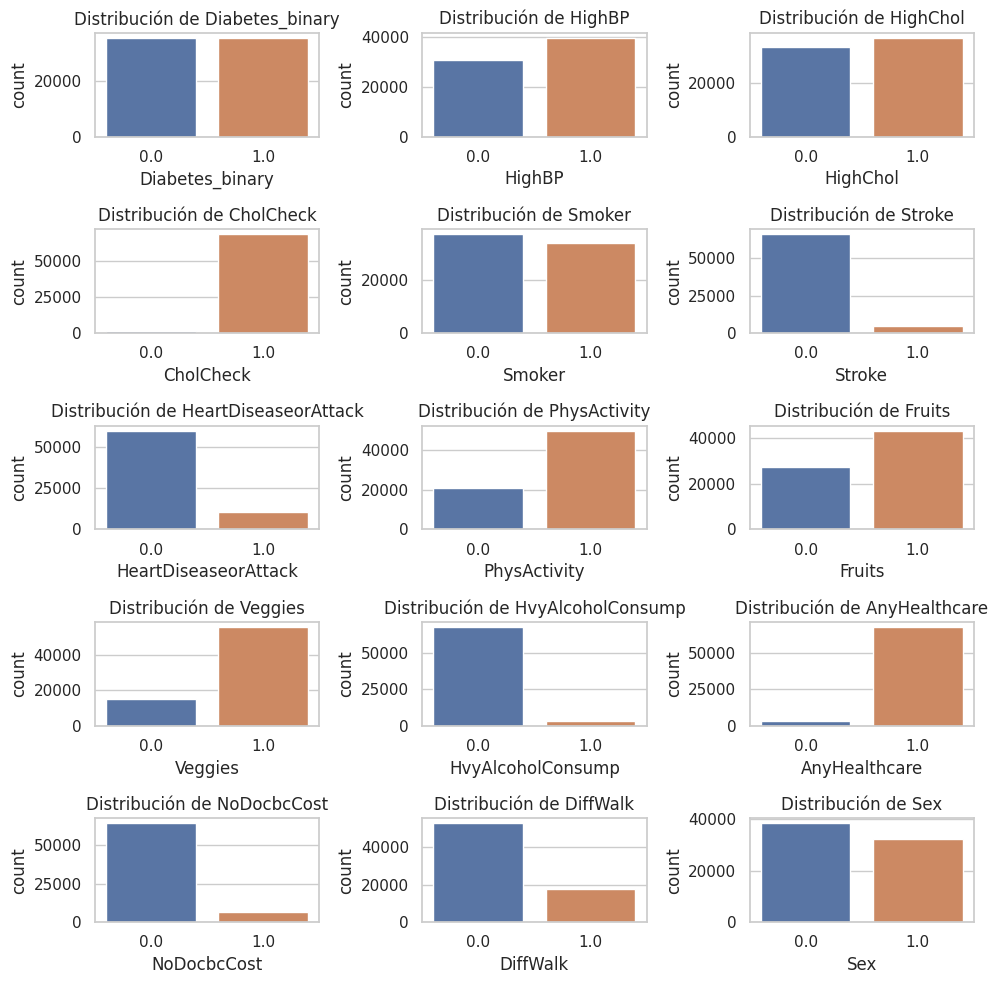

In [ ]:
# Visualizar distribuciones
sns.set(style="whitegrid")

# Ajustar el número de filas y columnas según la cantidad de características
num_features = len(columnas_binarias)  # Excluye la última columna (target)
num_rows = (num_features - 1) // 3 + 1
num_cols = min(3, num_features)

plt.figure(figsize=(10, 10))

for i, column in enumerate(columnas_binarias):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.countplot(x=df_diabetes5050[column])
    plt.title(f'Distribución de {column}')

plt.tight_layout()
plt.show()

Veamos ahora las columnas no binarias:

In [ ]:
columnas_no_binarias = [col for col in df_diabetes5050.columns if df_diabetes5050[col].nunique() != 2]

# Imprime la cantidad de columnas no binarias y sus nombres
print(f"Hay {len(columnas_no_binarias)} columnas no binarias")
print(columnas_no_binarias)

Hay 7 columnas no binarias
['BMI', 'GenHlth', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']


Las columnas no binarias son 7, aquí su descripción:

* BMI: indice de masa corporal
* GenHlth = percepción dle estado de salud del paciente, del 1 al 5 donde 1 = excelente;  2 = muy buena ; 3 = buena;  4 = regular;  5 = mala
* MentHlth = días de mala salud mental en los últimos 30 días, escala 1-30 días.
* PhysHlth = días de enfermedad o lesión física en los últimos 30 días escala 1-30.
* Age = edad, agrupada en 13 categorias (del 1 al 13),  agrupando cada 5 años, comenzando con el grupo 1 (de 18 a 24 años) el grupo 2 (de 25 a 29 años) etc el grupo 12 (de 75 a 79 años) y el 13 (mayor o igual a 80 anos).
* Education = Nivel de educación del 1 al 6 donde: 1=nunca estudió, 2= Elementary, 3 = Some high school, 4= High school graduate, 5= Some college or technical school, 6=College graduate.
* Income = escala de ingresos, del 1 al 8, donde 1 es para menores ingresos y 8 para mayores.

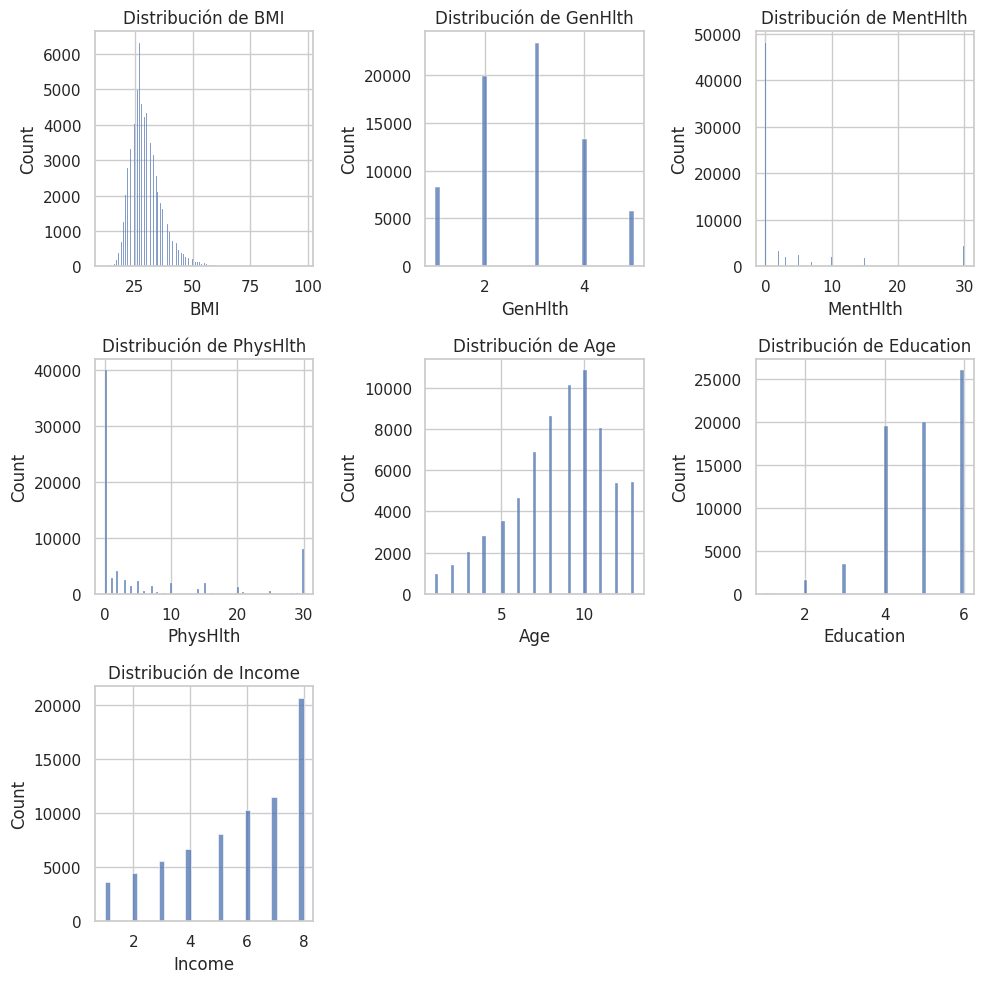

In [ ]:
# Visualizar distribuciones
sns.set(style="whitegrid")

# Ajustar el número de filas y columnas según la cantidad de características
num_features = len(columnas_no_binarias)
num_rows = (num_features - 1) // 3 + 1
num_cols = min(3, num_features)

plt.figure(figsize=(10, 10))

for i, column in enumerate(columnas_no_binarias):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.histplot(df_diabetes5050[column])
    plt.title(f'Distribución de {column}')

plt.tight_layout()
plt.show()

Podemos ver que tenemos 4 variables ordinales y hay 3 numéricas que son IBM, MentHlth y PhysHlth.
Esas 3 variables numéricas deberemos normalizar/escalar.

Como la distribución no es normal para MentHlth y PhysHlth vamos a usar el MinMaxScaler, al igual que para las columnas ordinales.

En cambio IBM tiene una distribución bastante normal, por lo que para esta variable usaremos el StandardScaler.

In [ ]:
df_scal = df_diabetes5050.copy()
df_scal

,Diabetes_binary,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,...,AnyHealthcare,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income
0,0.0,1.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,3.0,5.0,30.0,0.0,1.0,4.0,6.0,8.0
1,0.0,1.0,1.0,1.0,26.0,1.0,1.0,0.0,0.0,1.0,...,1.0,0.0,3.0,0.0,0.0,0.0,1.0,12.0,6.0,8.0
2,0.0,0.0,0.0,1.0,26.0,0.0,0.0,0.0,1.0,1.0,...,1.0,0.0,1.0,0.0,10.0,0.0,1.0,13.0,6.0,8.0
3,0.0,1.0,1.0,1.0,28.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,3.0,0.0,3.0,0.0,1.0,11.0,6.0,8.0
4,0.0,0.0,0.0,1.0,29.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,2.0,0.0,0.0,0.0,0.0,8.0,5.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
70687,1.0,0.0,1.0,1.0,37.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,0.0,0.0,6.0,4.0,1.0
70688,1.0,0.0,1.0,1.0,29.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,2.0,0.0,0.0,1.0,1.0,10.0,3.0,6.0
70689,1.0,1.0,1.0,1.0,25.0,0.0,0.0,1.0,0.0,1.0,...,1.0,0.0,5.0,15.0,0.0,1.0,0.0,13.0,6.0,4.0
70690,1.0,1.0,1.0,1.0,18.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,4.0,0.0,0.0,1.0,0.0,11.0,2.0,4.0


In [ ]:
scaler_MMS = MinMaxScaler()
scaler_SS = StandardScaler()

In [ ]:
colMM = ['GenHlth', 'MentHlth','PhysHlth', 'Education', 'Age', 'Income']
colSS = ['BMI']
colTotal = ['GenHlth', 'MentHlth','PhysHlth', 'Education', 'Age', 'Income','BMI']
col_no_scaled = [col for col in df_scal.columns if col not in colTotal]
#
columnasMM = scaler_MMS.fit_transform(df_scal[colMM])
columnasSS = scaler_SS.fit_transform(df_scal[colSS])

#
df_scal = pd.concat([df_scal[col_no_scaled], pd.DataFrame(columnasMM, columns=colMM), pd.DataFrame(columnasSS, columns=colSS)], axis=1)
df_scal[colTotal].describe()

,GenHlth,MentHlth,PhysHlth,Education,Age,Income,BMI
count,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,70692.000000,7.069200e+04
mean,0.459270,0.125068,0.193681,0.784191,0.632005,0.671187,-7.719358e-17
std,0.278391,0.271854,0.335409,0.205816,0.237679,0.310742,1.000007e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.510153e+00
25%,0.250000,0.000000,0.000000,0.600000,0.500000,0.428571,-6.827454e-01
50%,0.500000,0.000000,0.000000,0.800000,0.666667,0.714286,-1.204662e-01
75%,0.750000,0.066667,0.200000,1.000000,0.833333,1.000000,4.418130e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,9.578850e+00


Ya tenemos nuestro datframe listo para poder usarlo en las redes que construiremos.

Si bien hay dos columnas que nos parecen no tan importantes, que son la educación y la escala de ingresos, decidimos dejarlas (al menos en una primer instancia) debido a que tal vez tengan alguna incidencia en la predicción, aunque sea leve. Una segunda isntancia de prueba sería sacarlas y ver si las predicciones del modelo mejora.

### Separamos los datos en train, test y val:

Primero deberemos separar la variable target del resto, y luego dividir el datset en train, test y validación.

In [ ]:
# Separamos X e y
X = df_scal.drop('Diabetes_binary',axis=1).values
y = df_scal['Diabetes_binary'].values

In [ ]:
# Dividimos el conjunto de datos en conjuntos de entrenamiento, validación y test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=seed)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=seed)

Ahora debemos convertir todos estos datframe en tensores de Pytorch:

In [ ]:
X_train = torch.Tensor(X_train)
y_train = torch.LongTensor(y_train)

X_val = torch.Tensor(X_val)
y_val = torch.LongTensor(y_val)

X_test = torch.Tensor(X_test)
y_test = torch.LongTensor(y_test)

## 2. Implementación de red neuronal simple

Vamos a definir nuestra red neuronal:

Vamos a generar una clase llamada SimpleNN que hereda las propiedades de la clase nn.Module de pytorch. Y a esta clase le definiremos la arquitectura de nuestra red:

La capa de entrada que son las 21 variables, vamos a poner una sola capa oculta de 16 neuronas (es un valor que está entre el número de neurnas de entrada y el numero de neuronas de salida, y que es potencia de 2). Y la salida debe ser 2 ya que la variable target es binaria.

Además vamos a definir el método Forward pass donde ponemos la función de activación, que será la Relu de la capa de entrada a la capa oculta, y la softmax para la capa de salida. (viene por defecto en nn.module o en criterion)?????

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self,
                 input_features = 21, # Cantidad de features de entrada
                 hidden_layer   = 16, # Cantidad de neuronas de la unica capa oculta
                 output_features = 2  # Capa de salida, con 2 neuronas pues la variable target es binaria.
                 ):
        super().__init__() # Llama al método __init__ de la clase nn.Module

        # Generamos la red con 3 capas lineales (la última es de salida):
        self.fully_connected_1 = nn.Linear(input_features, hidden_layer)
        self.output = nn.Linear(hidden_layer, output_features)

    # definimos el método Foward pass:
    def forward(self, x):
      x = F.relu(self.fully_connected_1(x))
      x = self.output(x)
      return x

Ahora debemos instanciar la clase del modelo, y vamos a definir la función de pérdida. Como es un problema de clasificación elegimos utilizar la CrossEntropyLoss.

También definiremos acá el optimizador que elegimos probar el ADAM.

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val,  X_test, y_test, epochs=100, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    for epoch in tqdm.trange(epochs):
        epoch+=1
        # Foward pass y obtener la predicción en el conjunto de entrenamiento
        y_pred = model.forward(X_train)

        # Calcula la pérdida en el conjunto de entrenamiento
        loss_train = criterion(y_pred, y_train)
        train_losses.append(loss_train.item())
        # Calcula el acuracy en el conjunto de entrenamiento
        predictions_train = torch.argmax(y_pred, dim=1)
        accuracy_train = torch.sum(predictions_train == y_train).item() / len(y_train)
        train_accuracy.append(accuracy_train)

        # Setea todos los gradientes en cero, sino se acumulan
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()  # Actualiza todos los parámetros del modelo (pesos y sesgos)

        with torch.no_grad():
            # Foward pass y obtener la predicción en el conjunto de validación
            y_pred_val = model.forward(X_val)

            # Calcula la pérdida en el conjunto de validación
            loss_val = criterion(y_pred_val, y_val)
            val_losses.append(loss_val.item())
            #Calcula el accuracy en el conjunto de validación
            predictions_val = torch.argmax(y_pred_val, dim=1)
            accuracy_val = torch.sum(predictions_val == y_val).item() / len(y_val)
            val_accuracy.append(accuracy_val)
    # Evaluación en el conjunto de prueba
#    with torch.no_grad():
#        y_pred_test = model.forward(X_test)
#        loss_test = criterion(y_pred_test, y_test)
#        predictions = torch.argmax(y_pred_test, dim=1)
#        accuracy = torch.sum(predictions == y_test).item() / len(y_test)

    return train_losses, val_losses, train_accuracy, val_accuracy
# Entrenar y evaluar el modelo base
model_base = SimpleNN()
base_train_losses, base_val_losses, base_accuracy_train, base_accuracy_val = train_and_evaluate(model_base, X_train, y_train, X_val, y_val, X_test, y_test)


100%|██████████| 100/100 [00:03<00:00, 27.35it/s]


Veamos las gráficas de la función de Loss y del Accuracy tanto para el grupo de train como para el grupo de validación:

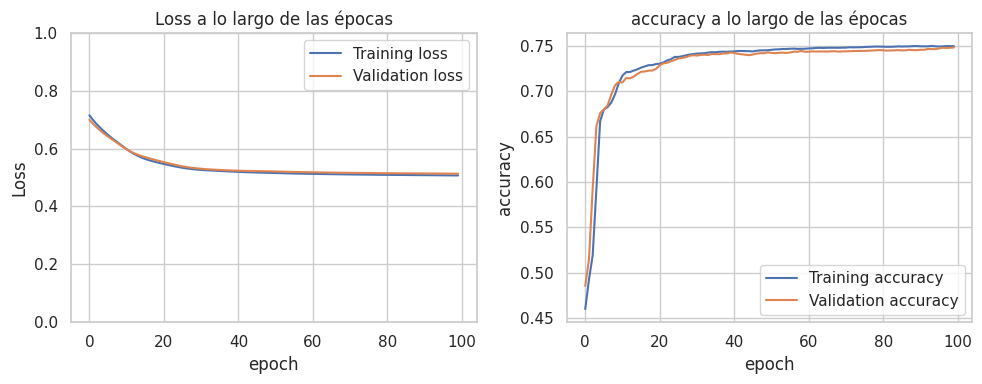

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].set_title('Loss a lo largo de las épocas')
axs[0].plot(base_train_losses, label='Training loss')
axs[0].plot(base_val_losses, label='Validation loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylim((0,1))
axs[0].legend()

axs[1].set_title('accuracy a lo largo de las épocas')
axs[1].plot(base_accuracy_train, label='Training accuracy')
axs[1].plot(base_accuracy_val, label='Validation accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend()

plt.tight_layout()
plt.show()

Podemos ver que no hay mucha diferencia entre la loss de train y de validacion, y que a partir de la época 50 aprox se estabiliza en cercca de 0.5

El accuracy también es muy similar entre los grupos de train y de validación, estabilizándose en valores cercanos a 0.75 a partir de la época nº 50.

## 3. Busqueda de hiperparametros buscando mejorar el baseline

Teniendo nuestra red simple, la baseline, vamos a experimentar variando diferentes hiperparámetros, buscando la red que nos de la menor loss y el mejor accuracy. Para ello podemos probar variar los siguientes hiperparámetros:

+ **Arquitectura**: además de nuestra SimleNN, podemos diseñar por ejemplo 2 redes más, una red IntermediaNN y otra BigNN, aumentando el número de capas ocultas y de neuronas en cada capa.

+ **Función de activación**: En nuestra SimpleNN hemos usado como función de activación la Relu. Podemos además probar con Sigmoid, Tanh, LeakRelu, Scaled Exponential Linear Unit (SELU), Exponential Linear Unit (ELU).

+ **Learning Rate**: En la red entrenada previamente usamos un lr de 0.01. Podemos probar por ejemplo con lr=0.0001, lr=0.05 para ver qué ocurre con tasas más pequeñas, ya que 0.01 suele ser de las más altas.

+ **Optimizadores**: Al entrenar la red anterior usamos ADAM, podemos probar usando Adagrad, SGD (Descenso por el gradiente estocástico), RMSprop.


### Arquitectura

Vamos a diseñar dos redes más complejas, aumentando en cada caso la complejidad por medio del número de capas ocultas y el número de neuronas en cada capa. Vamos a dejar la función loss la CrossEntropyLoss, como función de activación la Relu, como optimizador el ADAM y sólo en el caso de la BigNN agregaremos un dropout del 20%.

**IntermediateNN**: vamos a agregar una capa oculta, es decir que pasamos a tener 3 capas ocultas, y la de entrada y la de salida. Las capas ocultas tendrán 32, 16 y 8 neuronas. La capa de entrada tiene 21 ya que son las features del dataset y la de salida tiene 2 pues es una clasificación binaria.

**BigNN**: En esta nueva red neuronal vamos a tener ahora 4 capas ocultas, con 64,32,16 y 8 neuronas, la de entrada y la de salida.
En este caso vamos a agregar un dropout del 20%.

En ambos casos mantenemos la función de loss CrossEntropy, la función de activación de todas las capas menos la de salida como la Relu, y la de salida es la softmax. Y también mantenemos el optimizador ADAM.

In [ ]:
# Modelo 1
class IntermediateNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(21, 32)  # 1º capa oculta de 32 neuronas
        self.fc2 = nn.Linear(32, 16)  # 2º capa oculta de 16 neuronas
        self.fc3 = nn.Linear(16, 8)   # 3º capa oculta de 8 neuronas
        self.output_layer = nn.Linear(8, 2) #capa de salida de 2 neuronas


    def forward(self, x):
        x = F.relu(self.fc1(x))  # ReLU
        x = F.relu(self.fc2(x))  # ReLU
        x = F.relu(self.fc3(x))  # Relu
        x = self.output_layer(x)
        return x



# Modelo modificado 2
class BigNN(nn.Module):
  def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(21, 64)  # 1º capa oculta de 64 neuronas
        self.fc2 = nn.Linear(64, 32)  # 2º capa oculta de 32 neuronas
        self.fc3 = nn.Linear(32, 16)  # 3º capa oculta de 16 neuronas
        self.fc4 = nn.Linear(16, 8)   # 4º capa oculta de 8 neuronas
        self.output_layer = nn.Linear(8, 2)
        self.dropout = nn.Dropout(0.2)  # Agregado un dropout de 20%

  def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = F.relu(self.fc4(x))
        x = self.output_layer(x)
        return x

In [ ]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, epochs=100, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []

    for epoch in tqdm.trange(epochs):
        # Foward pass y obtener la predicción en el conjunto de entrenamiento
        y_pred = model.forward(X_train)

        # Calcula la pérdida en el conjunto de entrenamiento
        loss_train = criterion(y_pred, y_train)
        train_losses.append(loss_train.item())
        # Calcula el acuracy en el conjunto de entrenamiento
        predictions_train = torch.argmax(y_pred, dim=1)
        accuracy_train = torch.sum(predictions_train == y_train).item() / len(y_train)
        train_accuracy.append(accuracy_train)

        # Setea todos los gradientes en cero, sino se acumulan
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()  # Actualiza todos los parámetros del modelo (pesos y sesgos)

        with torch.no_grad():
            # Foward pass y obtener la predicción en el conjunto de validación
            y_pred_val = model.forward(X_val)

            # Calcula la pérdida en el conjunto de validación
            loss_val = criterion(y_pred_val, y_val)
            val_losses.append(loss_val.item())
            #Calcula el accuracy en el conjunto de validación
            predictions_val = torch.argmax(y_pred_val, dim=1)
            accuracy_val = torch.sum(predictions_val == y_val).item() / len(y_val)
            val_accuracy.append(accuracy_val)

    return train_losses, val_losses, train_accuracy, val_accuracy

# Entrenar y evaluar el primer modelo modificado
model_inter = IntermediateNN()
inter_train_losses, inter_val_losses, inter_accuracy_train, inter_accuracy_val = train_and_evaluate(model_inter, X_train, y_train, X_val, y_val, X_test, y_test)

# Entrenar y evaluar el segundo modelo modificado
model_big = BigNN()
big_train_losses, big_val_losses, big_accuracy_train, big_accuracy_val= train_and_evaluate(model_big, X_train, y_train, X_val, y_val, X_test, y_test)


100%|██████████| 100/100 [00:13<00:00,  7.22it/s]


Veamos las curvas de loss y accuracy para todos los modelos, para ver si hemos mejorado la performance al aumentar la complejidad:

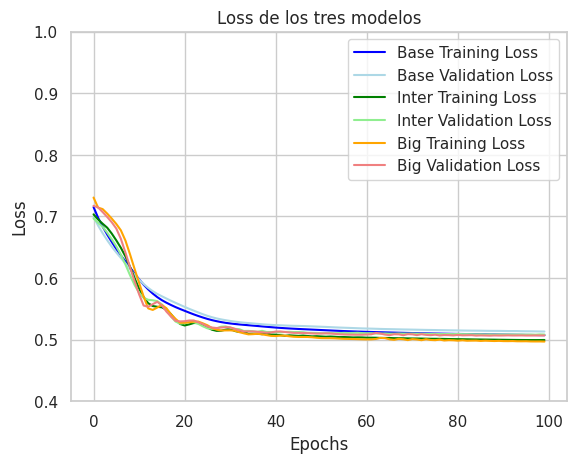

In [ ]:
# Visualización de las curvas de pérdida de todos los modelos
# Base
plt.plot(base_train_losses, label='Base Training Loss', color='blue')
plt.plot(base_val_losses, label='Base Validation Loss', color='lightblue')

# Modelo 1
plt.plot(inter_train_losses, label='Inter Training Loss', color='green')
plt.plot(inter_val_losses, label='Inter Validation Loss', color='lightgreen')

# Modelo 2
plt.plot(big_train_losses, label='Big Training Loss', color='orange')
plt.plot(big_val_losses, label='Big Validation Loss', color='lightcoral')
#
plt.title('Loss de los tres modelos')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0.4,1))
plt.legend()
plt.show()

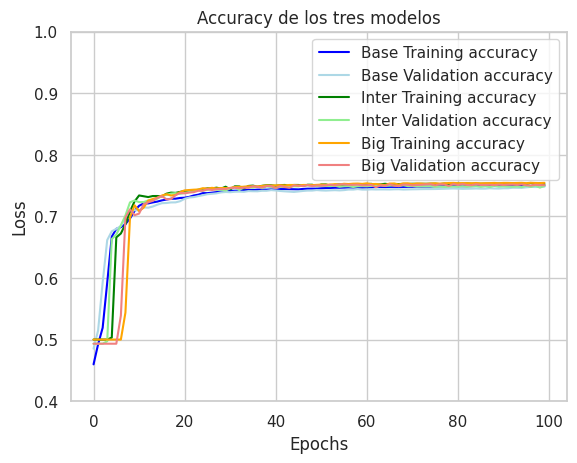

In [ ]:
# Visualización de las curvas de accuracy de todos los modelos
# Base
plt.plot(base_accuracy_train, label='Base Training accuracy', color='blue')
plt.plot(base_accuracy_val, label='Base Validation accuracy', color='lightblue')

# Modelo 1
plt.plot(inter_accuracy_train, label='Inter Training accuracy', color='green')
plt.plot(inter_accuracy_val, label='Inter Validation accuracy', color='lightgreen')

# Modelo 2
plt.plot(big_accuracy_train, label='Big Training accuracy', color='orange')
plt.plot(big_accuracy_val, label='Big Validation accuracy', color='lightcoral')
#
plt.title('Accuracy de los tres modelos')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0.4,1))
plt.legend()
plt.show()

Podemos ver que con ninguna de las dos redes más complejas hemos logrado disminuir significativamente la loss de 0.5 ni subir el accuracy de 0.75, por lo tanto elegimos la red más sencilla que es la base.

### Learning rate

Se hicieron experimentos variando el learning rate, con valores desde 0.001 a 0.05, mostramos aquí sólo los resultados, para no tener que ejecutar más de 3 modleos.

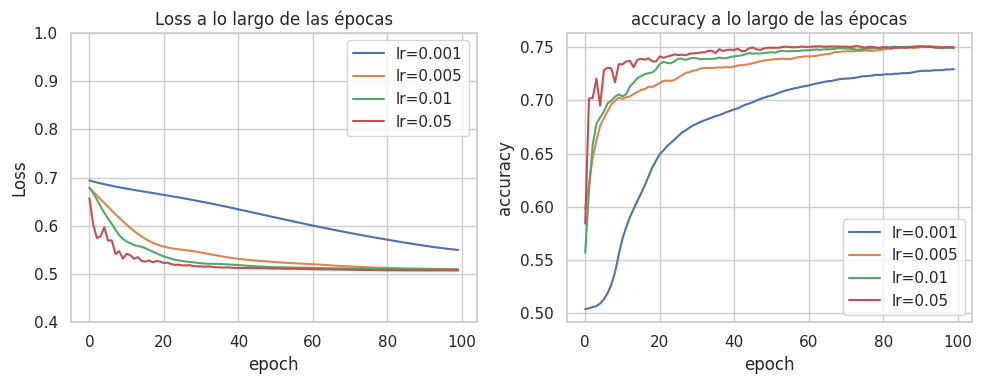

Podemos ver que el modelo funciona mejor para learning rates más grandes, y en ningún caso supera el accuracy de 0.75, ni baja la loss de 0.5.
Como vemos más fluctuaciones para el learning rate de lr=0.05 que para el de lr=0.01, decidimos elegir el lr=0.01.

### Función Activación

También probamos cambiando la función de activación, entre la capa de entrada y la capa oculta (para la capa de salida   siempre se dejó la la función de activación softmax).
Mostramos aquí los resultados:

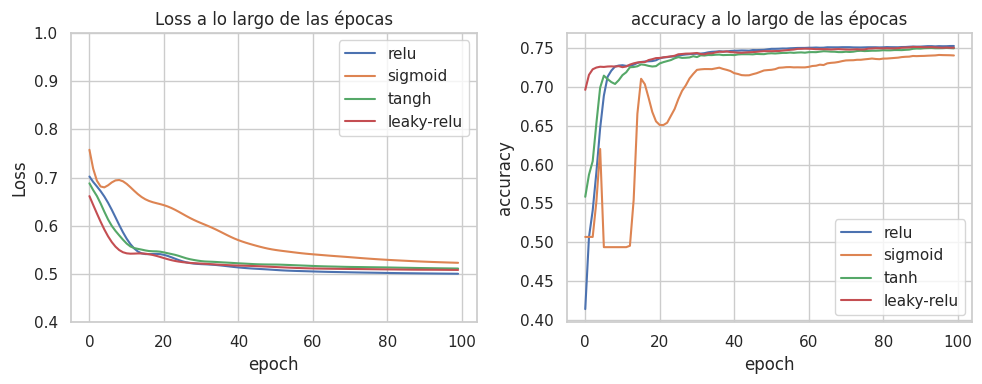

Podemos ver que la función sigmoide es la que peor funciona.
Y podemos ver que si bien para las primeras épocas la función relu es la peor de las otras 3, a épocas grandes la funcíon relu es la que tiene menos loss, y respecto al accuracy las 3 se estabilizan en valores de 0.75.
En ninguno de los casos se logra bajar de loss 0.5 ni subir de accuracy 0.75.

Por lo tanto elegimos la funcion relu.

### Optimizadores

También probamos 3 optimizadores diferentes: ADAM, RMprop y  Adgrad. Mostramos los resultados en el siguiente gráfico:

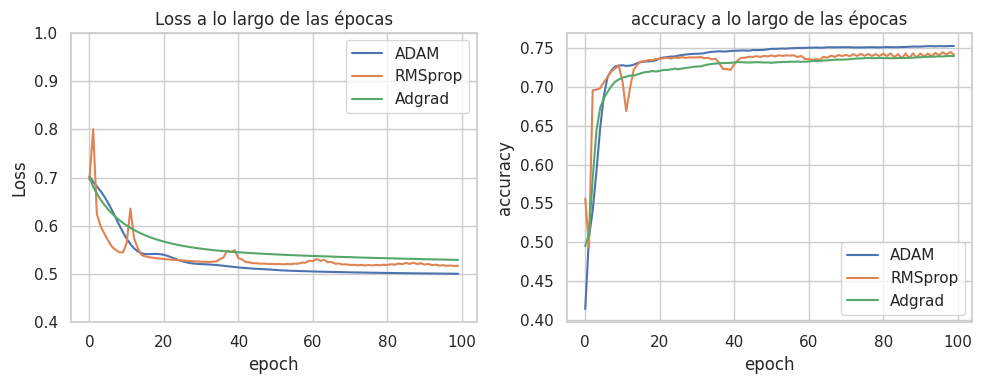

Podemos ver que RMSprop es el más inestable de todos, y que el que mejor funciona es el ADAM, tanto porque es el que tiene menor loss como el que tiene mayor accuracy.

## Prueba final en test

Habiendo elegido ya todos los hiperparámetros, vamos a hacer una última corrida del modelo con esos hiperparámetros en el grupo de test.

Los hiperparámetros son:

* Arquitectura: SimpleNN
* Función de activación: Relu
* Learning rate: 0.01
* Optimizador: ADAM


Vamos a volver a entrenar la red con el grupo de train, y luego veremos cómo anduvo el modelo en el grupo de test, comparando tmb la loss y el accuracy entre ambos grupos para ver si hay overfiting

In [ ]:
class SimpleNN(nn.Module):
    def __init__(self,
                 input_features = 21, # Cantidad de features de entrada
                 hidden_layer   = 16, # Cantidad de neuronas de la unica capa oculta
                 output_features = 2  # Capa de salida, con 2 neuronas pues la variable target es binaria.
                 ):
        super().__init__() # Llama al método __init__ de la clase nn.Module

        # Generamos la red con 3 capas lineales (la última es de salida):
        self.fully_connected_1 = nn.Linear(input_features, hidden_layer)
        self.output = nn.Linear(hidden_layer, output_features)

    # definimos el método Foward pass:
    def forward(self, x):
      x = F.relu(self.fully_connected_1(x))
      x = self.output(x)
      return x

In [ ]:
def test_and_evaluate(model,  X_train, y_train, X_test, y_test, epochs=100, lr=0.01):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    train_accuracy = []
    test_losses = []
    test_accuracy = []

    for epoch in tqdm.trange(epochs):
        epoch+=1
        # Foward pass y obtener la predicción en el conjunto de entrenamiento
        y_pred = model.forward(X_train)

        # Calcula la pérdida en el conjunto de entrenamiento
        loss_train = criterion(y_pred, y_train)
        train_losses.append(loss_train.item())
        # Calcula el acuracy en el conjunto de entrenamiento
        predictions_train = torch.argmax(y_pred, dim=1)
        accuracy_train = torch.sum(predictions_train == y_train).item() / len(y_train)
        train_accuracy.append(accuracy_train)

        # Setea todos los gradientes en cero, sino se acumulan
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()  # Actualiza todos los parámetros del modelo (pesos y sesgos)

        with torch.no_grad():
            # Foward pass y obtener la predicción en el conjunto de test
            y_pred_test = model.forward(X_test)

            # Calcula la pérdida en el conjunto de test
            loss_test = criterion(y_pred_test, y_test)
            test_losses.append(loss_test.item())
            #Calcula el accuracy en el conjunto de test
            predictions_test = torch.argmax(y_pred_test, dim=1)
            accuracy_test = torch.sum(predictions_test == y_test).item() / len(y_test)
            test_accuracy.append(accuracy_test)


    return train_losses, train_accuracy, test_losses, test_accuracy
# Entrenar y evaluar el modelo base
model_base = SimpleNN()
losses_train_final, accuracy_train_final, losses_test_final, accuracy_test_final  = test_and_evaluate(model_base, X_train, y_train,  X_test, y_test)

100%|██████████| 100/100 [00:02<00:00, 49.72it/s]


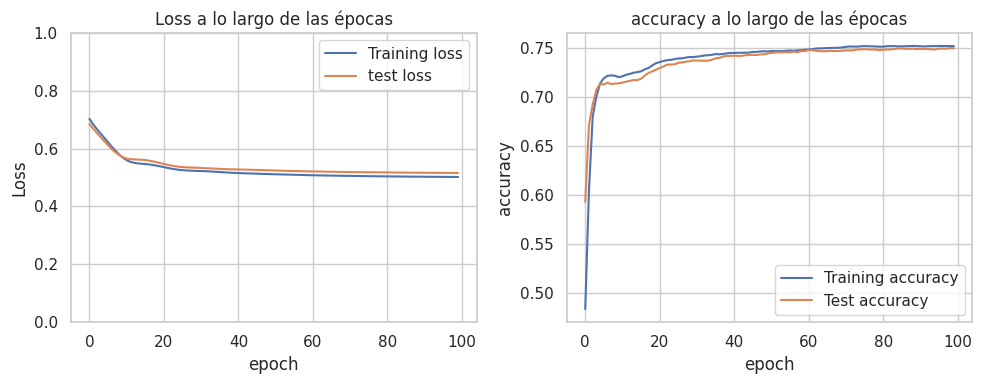

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].set_title('Loss a lo largo de las épocas')
axs[0].plot(losses_train_final, label='Training loss')
axs[0].plot(losses_test_final, label='test loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('epoch')
axs[0].set_ylim((0,1))
axs[0].legend()

axs[1].set_title('accuracy a lo largo de las épocas')
axs[1].plot(accuracy_train_final, label='Training accuracy')
axs[1].plot(accuracy_test_final, label='Test accuracy')
axs[1].set_ylabel('accuracy')
axs[1].set_xlabel('epoch')
axs[1].legend()

plt.tight_layout()
plt.show()

Podemos ver que el modelo funciona bien en el grupo de test, ya que la loss es muy similar al grupo de training, apenas un poquito mas alto, llegando a 0.5. También en el accuracy el grupo de test llega a valores cercanos a 0.75, siendo apenas más bajo que para el grupo de training.

Podemos concluir que el modelo está aprendiendo, y generaliza bien.

## Conclusiones Finales:

Hemos generado un modelo de red neuronal para determinar si los pacientes tienen o no diabetes. El modelo utiliza un conjunto de 21 características, en una red neuronal del full conected con backpropagation.

Probamos diferentes arquitecturas, y resultó que la más sencilla es la que mejor funciona. Esta red consta de una sola capa oculta, de 16 neuronas, además de la capa de entrada (21 neuronas) y la capa de salida (dos neuronas, pues es un modelo de clasificación binaria: si tiene diabetes, no tiene diabetes).

Como es un problema de clasificación binaria utilizamos para el cálculo de la función de pérdida la CrossEntropy.

Probamos diferentes optimizadores, diferentes funciones de activación para la capa oculta y diferentes learning rates.

El modelo elegido resultó ser el de la arquitectura más sencilla, el mencionado previamente, con un optimizador ADAM, una función de activación RELU, y un learning rate de lr=0.01.
En nuestro modelo la función de loss desciende asintóticamente hacia un valor de 0.5, que es la loss más baja obtenida entre todos los modelos probados. También adquiere una presición de 0.75, siendo éste el valor al que llegan todos los modelos probados (salvo uno que llega a 0.72).

También observamos que no hay mucha diferencia en los resultados de los diferentes modelos, salvo que algunas curvas son más inestables que otras, y apenas pequeñas variaciones en la loss o el accuracy.

Como punto para un posterior análisis podríamos estudiar cómo cambia para diferentes batch size, y también analizar diferentes momentum de el optimizador SGD.